# A quick-start introduction to Stan for economists


Stan is a flexible modeling language that makes it straightforward to estimate a very wide range of probability models using Bayesian techniques. There are a few reasons one may want to spend the time to learn Stan: 

- Stan implements efficient estimation of probability models on large data sets using Hamiltonain Monte Carlo, Variational Inference and Penalised Maximum Likelihood. Stan can be called from many environments that users may use for data preparation, including R, Python, Stata, Julia and Matlab. 
- Stan allows users to speed up their R code by exporting Stan functions (which are compiled C++ functions) into R. This is especially useful for users who want similar performance to Julia but are tied to R for its large library ecosystem.
- Stan is perhaps the easiest Bayesian library to learn and use, with straightforward syntax and companion libraries for easy model checking and comparison. 
- Stan (alongside the workflow that is encouraged by the Stan community) forces users to think more carefully about their models than they may do otherwise. Learning Stan illuminates many aspects of statistics that you may have skipped over; it should help you think more carefully about modeling even if you do not use Stan. 
- In Stan there is no penalty from using non-conjugate prior distributions, allowing far richer model specifications than under other MCMC methods. 

By the end of this tutorial, you should feel comfortable with the following: 

1. Understand the Bayesian workflow 
2. Know how to write out a Stan model
3. Know how to estimate and check a model in R
4. Know where to get help

The examples given below will use R's interface with Stan, `rstan`. While Stan can also be called from Python (using `PyStan`), Julia (using `Stan.jl`) and other environments, there are some useful companion libraries that are better developed in R. 


## 1. The Bayesian Workflow

A strong culture exists within the Bayesian community around a workflow that promotes high quality modeling. Many of the steps should be familiar to economists, yet a few are distinct to Bayesian modeling.

   - Write out the full probability model. That is, a joint probability model of all data and parameters of the model. 
   - Simulate the model with known values for the parameters.
   - Estimate the model to recover the parameters from simulated data.
   - Estimate the model against real data.
   - Check that the estimation has run properly.
   - Run posterior predictive checking/time series cross validation to evaluate model fit.
   - Perform inference and prediction.
   - Model comparison.
   - Iterate!

We typically start this workflow with the simplest possible model. Only once this is running through the entire workflow without problems do we add richness. Starting simple and adding layers of complexity decreases the scope for error at each iteration; it also gives you a working model to fall back on if your model falls over, allowing you to more easily pinpoint where problems might happen. It is worthwhile building each layer of complexity on a different feature [git branch](https://www.atlassian.com/git/tutorials/), to minimise the possibility of contamination. 

While at first it may seem a drag to adhere to this workflow strictly, after a while it should feel natural. It will reduce the number of errors in your work, and help you think through the details of the modeling task. 

Let's walk through each step, gradually introducing Stan along the way. 

### A quick note on notation

The tutorial below uses probabilistic notation. 

- In probabilistic modeling, each random variable is associated with a probability density function (for continuous random variables) or probability mass function (for discrete random variables), in generic notation $p()$. 
- The _density_ at a given point $y_{i}$ is $p(y_{i})$. 
- The probability that some particular value of our random variable $y$, $y_{i}$ will fall between two points $lower$ and $upper$ is $\int_{lower}^{upper}p(y)dy$, the area under the probability density function between those two points. Accordingly the area under a probability density is always equal to 1.  
- A distribution of some data $y$ _that does not depend on the value of any other random variables_, is written $p(y)$. Because its distribution is not conditioned on the values of any other random variables, we call this an _unconditional distribution_. An unconditional distribution can still have parameters, but these are treated as fixed values.
- In Bayesian analysis, the unconditional (joint) distribution of the parameters of a model, normally lumped together into a single vector $\theta$, is called the _prior distribution_, $p(\theta)$. 
- If the distribution of a random variable is conditional on the values of another random variable, we write the probability distribution as being _conditional_. For instance, $p(y\, |\, \theta)$ is the (generic) probability distribution of $y$ given some parameter vector $\theta$, a given realization of a random variable. 
- We can generate random draws from a probability density where the probability of a draw at a given value is proportional to the density at that point. 
- In cases where the data $y$ and parameters $\theta$ are fixed, the notation $L(\theta) = p(y\, |\, \theta)$ is also used to denote the value of the _likelihood function_, which is the product of the densities for all the data points $y_{i}\in y$.
- Let $\theta = (\mu, \sigma)$, an expected value (mean) and scale parameter. If we say $y\, |\, \theta \sim \mbox{Normal}(\mu, \sigma)$, this is read that the variable $y$ _is distributed according to_ a normal distribution with expected value of $\mu$ and standard deviation of $\sigma$. 
- In this tutorial below we drop the conditional statement on the lefthand and shorten this expression to $y \sim \mbox{Normal}(\mu, \sigma)$ as it is clear that $y$'s distribution depends on $\mu$ and $\sigma$.
- A distribution with _conditional expected value and scale_ is when each observation of $y$, $y_{i}$, depends on its own set of parameters modeled as random variable. In the normal case, $y_{i} \sim \mbox{Normal}(\mu_{i}, \sigma_{i})$. Much statistical modeling is simply coming up with functional forms for $\mu_{i}$ and $\sigma_{i}$; for instance in the normal linear model, $\mu_{i} = X_{i}\beta$ and $\sigma_{i} = \sigma$, where $\theta = (\beta, \sigma)$ is a modeled as a random variable. 
- The likelihood of a normal linear model is often written $p(y\, |\, \beta, \sigma)$. Yet the distribution of $y$ is clearly dependent on the conditional expected value $X\beta$, so sometimes you will see it written more completely as $p(y\, |\, \beta, \sigma, X)$. If you have conditioning information in X you should always think of it being present in conditional distributions, even if it's not explicitly stated. 


### A) Writing out your model in probability form

Stan estimates probability models. These are models in which we assume that all unknown parameters and the outcome variable(s) $y$ each come from some (conditional) probability density.

As a first example, take the linear regression model. In this model we have an ($N$-long) vector of outcomes $y$, a matrix of covariates $X$ ($N\times P$), a ($P$-long) vector of unknown coefficients $\beta$, and a ($N$-long) vector of residuals $\epsilon$. The model is typically written out in matrix notation as

$$
y = X\beta + \epsilon
$$

This is not yet a probability model. To express it as a probability model, we make an assumption about the distribution of the residuals and parameters. We'll start by assuming the residuals are normally distributed $\epsilon \sim \mbox{Normal}(0, \sigma)$, where $\sigma$ is another parmeter--the standard deviation of the residuals. 

Once we have made this distributional assumption, we can use it to express the linear model above in probability notation.

$$
y = X\beta + \epsilon \mbox{ and } \epsilon \sim \mbox{Normal}(0, \sigma) \implies y \sim \mbox{Normal}(X\beta, \sigma)
$$

(This follows from the fact that if we add $X\beta$ to $\epsilon$, we have a new distribution with an expected value of $X\beta$.) 

Note that the normal distribution $\mbox{Normal}(\mu, \sigma)$ is a _two-parameter_ distribution. It has an expected value of $\mu$ and standard deviation $\sigma$. This does not stop us from estimating a model that has a function for each parameter that itself may have several parameters--in the case above, we're using a linear function $\mu = X\beta$ (with $P$ regression coefficients in $\beta$) for the mean model.

The model $y \sim \mbox{Normal}(X\beta, \sigma)$ is the _data model_. If we knew the value of the parameters $\beta$ and $\sigma$ for certain, we could simulate plausible values for an outcome $y_{i}^{\mathrm{sim}}$ for a given set of covariates $X_{i}$ simply by generating random numbers drawn from $\mbox{Normal}(X_{i}\beta, \sigma)$. (This gets to an important aspect of Bayesian models: there is no _predicted value_, rather a _predictive distribution_). However, because we don't know $\beta$ and $\sigma$ for certain, we will generate probabilistic estimates for them. 

In Bayesian statistics we try to learn about a _posterior_ density, in this case (where $\theta = (\beta, \sigma)$) the posterior density is $p(\theta | y, X)$--a joint density of the parameters given the data. According to Bayes' law, this density is given by 

$$
p(\theta | y, X) = \frac{p(y | \theta, X)\times p(\theta)}{p(y)}
$$

Because the density $p(y)$ does not depend on the values of $\theta$, we typically ignore the denominator of this expression and write it out up to a constant of proportionality. That is

$$
p(\theta | y, X) \propto p(y | \theta, X)\times p(\theta)
$$


If we assume that the prior distributions of $\beta$ and $\sigma$ are independent, then $p(\theta) = p(\beta)\times p(\sigma)$, and this becomes

$$
p(\beta, \sigma | y, X) \propto p(y | \beta, \sigma, X)\times p(\beta)\times p(\sigma)
$$


Now let's examine the term $p(y|\beta, \sigma, X)$--the probability density of $y$ given the parameters and covariates. We already made a modeling assumption about this distribution--it is our data model $\mbox{Normal}(X_{i}\beta, \sigma)$.

#### A2) Choosing priors

To complete (and estimate) our probability model, we need to specify priors for the parameters $\beta$ and $\sigma$. 

First, what do priors do? Informally: 

- Priors pull our estimate of the posterior density away from the likelhood in the direction of the prior. The less information contained in the data, the more pronounced this effect will be. 
- Priors help (mathematically, not causally) identify models. For instance, imagine a regression $y = \alpha + \beta x + \epsilon$, where for a particular sample, every observation of $x=0$. $\beta$ is not identified--it could take on any value without affecting the plausibility of the model. Adding prior information about $\beta$ identifies this model. Our posterior estimate of $\beta$ in this case would simply be the prior. 
- Priors can help _constrain_ our estimates of posterior distributions. More on this below. 

For regression coefficients that do not vary across groups, we often use univariate normal priors; if coefficients vary across groups, we typically specify multivariate normal priors. The expected value and scale of the prior distributions can be used to include information that is known before observing the data, such as parameter estimates from a meta-study, or a theoretically imposed value. It is also common to use so-called _shrinkage priors_ or _regularising priors_. These are priors that _shrink_ the estimate towards 0 (or a group mean). In many prediction tasks, shrinkage priors help prevent overfitting.

An important note on prior distributions: if a prior distribution puts no weight on a particular value of the parameter, the posterior distribution cannot put weight on that value either. We can use this property by choosing prior distributions that restrict estimates of $\beta$ to economically meaningful values. For instance, if we are estimating a very simple cost function $\mbox{costs} = \alpha + \beta\, \mbox{quantity_sold} + \epsilon$, we may want to exclude the possibility of zero or negative fixed costs (that is, we think that $\alpha> 0$). In such a case, we could give $\alpha$ a prior distribution that is only defined for positive values, such as a truncated normal distribution, the lognormal distribution, or a gamma distribution. 

Similarly, the prior for $\sigma$ should be constrained to positive numbers. A convenient prior for standard deviations is the half Cauchy distribution (restricted to positive numbers), which provides some prior information but allows for potentially large standard deviations. 

#### Putting it all together

We now have our probability model. It is made up of two prior distributions for the parameters (one for the $\beta$s, one for the $\sigma$), and a model for the data given the parameters. 

Where $\mu_{p}, \sigma_{p}, x_{0}\mbox{ and } \gamma$ are fixed numbers (not parameters to be estimated) that summarise prior information and are chosen by the researcher. We have the priors: 

$$
\mbox{for }p\in [1 \dots P] \mbox{    }\beta_{p} \sim\mbox{Normal}(\mu_{p}, \sigma_{p})
$$

$$
\sigma \sim\mbox{Cauchy}_{+}(x_{0}, \gamma)
$$

And the data model

$$
y \sim\mbox{Normal}(X\beta, \sigma)
$$


#### A slightly richer model

The illustration above shows _how_ you could put together a simple probability model, but does not motivate _why_ you might want to. The real power of probabilistic modeling is that it is not much harder to define far richer models than simple ones. 

For instance, let's say that we want to make two changes to the model above. First, we'd like to accept that our outcome $y$ might come from a so-called "fat tail" distribution like the student's t distribution. Next, we want to restrict the first element of $\beta$ to be non-negative. We can define this slightly richer model like so: 

Priors: 

$$
\beta_{1} \sim\mbox{Normal}_{+}(\mu_{1}, \sigma_{1})
$$

$$
\mbox{for }p\in [2 \dots P] \mbox{    }\beta_{p} \sim\mbox{Normal}(\mu_{p}, \sigma_{p})
$$

$$
\sigma \sim\mbox{Cauchy}_{+}(x_{0}, \gamma)
$$

And the data model

$$
y \sim\mbox{Student's t}(\nu, X\beta, \sigma)
$$

Where $\nu$ is the degrees of freedom of the student's t distribution. We need to give this parameter a prior also, limited below by 0. As the student's t distribution approaches a normal distribution as $\nu$ gets much above 20, we may want to centre our distribution around 7, with a fairly wide spread. 

$$
\nu \sim \mbox{Cauchy}_{+}(7, 5)
$$



### B) Simulating the model with known parameters (an introduction to Stan)

We have now specified two probability models. What we will do next is simulate some data _from the second (more complex model)_, and then check to see if we can recover the (known) model parameters by estimating both the correctly specified and incorrectly specified models above. Simulating and recovering known parameters is an important checking procedure in model building; it often helps catch errors in the model and clarifies the model in the mind of the modeler.  While it would be trivial to do in your statistics package of choice, we'll use this task as an opportunity to introduce writing out data generating models in Stan. 

A Stan model is comprised of code blocks. Each block is a place for a certain task. The bold blocks below must be present in all Stan programs (even if they contain no arguments): 

1. `functions`, where we define functions to be used in the blocks below. **This is where we will write out a random number generator that gives us draws from our assumed model**. 
2. **`data`**, declares the data to be used for the model
3. `transformed data`, makes transformations of the data passed in above
4. **`parameters`**, defines the unknowns to be estimated, including any restrictions on their values. 
5. `transformed parameters`, often it is preferable to work with transformations of the parameters and data declared above; in this case we define them here. 
6. **`model`**, where the full probability model is defined. 
7. `generated quantities`, generates a range of outputs from the model (posterior predictions, forecasts, values of loss functions, etc.). 

Below is the R and Stan script to perform the task. 

First we need to load some libraries. I normally use `dplyr` for data munging, `ggplot2` for plotting the parameters, `rstan`, which is R's interface with Stan, and `reshape2`, which I use to manipulate parameter draws. 

In [3]:
# In R:
# Load necessary libraries and set up multi-core processing for Stan
options(warn=-1, message =-1)
library(dplyr); library(ggplot2); library(rstan); library(reshape2)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


Next we define the data generating process. Note that you can define this as a string defined in R, as I have done below, or as a text file that is saved with a `.stan` suffix. The script below is annotated. A few things to notice: 

- Stan writes C++ programs, and so requires static typing (that is, defining the data and variables by their type). In the function that we declare below, arguments include vectors using `vector` an integer using `int`, some reals `real` and a matrix, using `matrix`. 
- All random number generators in Stan are distribution names followed by `_rng`. This includes any functions that you write. 
- A very complete account of the Stan language is available in the [Stan Modeling Language User's Guide and Reference Manual](http://mc-stan.org/documentation/). 


In [4]:
# In R, or you could save the contents of the string in a file with .stan file type

dgp_string <- "
/**
   * Return draws from a linear regression with data matrix X,
   * coefficients beta, and student-t noise with degrees of freedom nu
   * and scale sigma.
   *
   * @param X Data matrix (N x P)
   * @param beta Coefficient vector (P x 1)
   * @param nu Residual distribution degrees of freedom.
   * @param sigma Residual distribution scale.
   * @return Return an N-vector of draws from the model.
   */
functions {
    vector dgp_rng(matrix X, vector beta, real nu, real sigma) {
      vector[rows(X)] y; // define the output
      
      // Now fill it in
      for (n in 1:rows(X))
        y[i] <- student_t_rng(nu, X[n] * beta, sigma);
      return y;
   }
}
data {
 // If we were estimating a model, we'd define the data inputs here
}
parameters {
  // ... and the parameters we want to estimate would go in here
}
model {
  // This is where the probability model we want to estimate would go
}
generated quantities {
}
"

Now that we have written out the data generating model, let's generate some known parameter and covariates, and simulate the model. First: generate some values for the data and paramaters. 

In [5]:
# Generate a matrix of random numbers, and values for beta, nu and sigma

set.seed(42) # Set the random number generator seed so that we get the same parameters
N <- 1000 # Number of observations
P <- 10 # Number of covariates
X <- matrix(rnorm(N*P), N, P) # generate an N*P covariate matrix of random data
nu <- 5 # Set degrees of freedom
sigma <- 5 # And scale parameter
beta <- rnorm(10) # Generate some random coefficients that we'll try to recover
# Make sure the first element of beta is positive as in our chosen DGP
beta[1] <- abs(beta[1])

Now that we have the inputs to our model, we should compile the script above. Stan uses templating to turn your script into a C++ script, which is then compiled. We're going to compile the script using `stan_model()`, and then make the function that we declared available to R using `expose_stan_functions()`. 

This is a useful feature: especially when you are using nested loops, Stan functions can be several orders of magnitude faster than R functions. 

In [6]:
# Compile the script
compiled_function <- stan_model(model_code = dgp_string) # you could use file = "path/to/yourfile.stan" if you have saved it as so
# And make the function available to the user in R
expose_stan_functions(compiled_function)

And now our `dgp_rng()` is available in R. Let's use it along with the data we declared above to simulate some fake data. Again--the reason we want to do this is to make sure that we can recover known parameters from our data. 

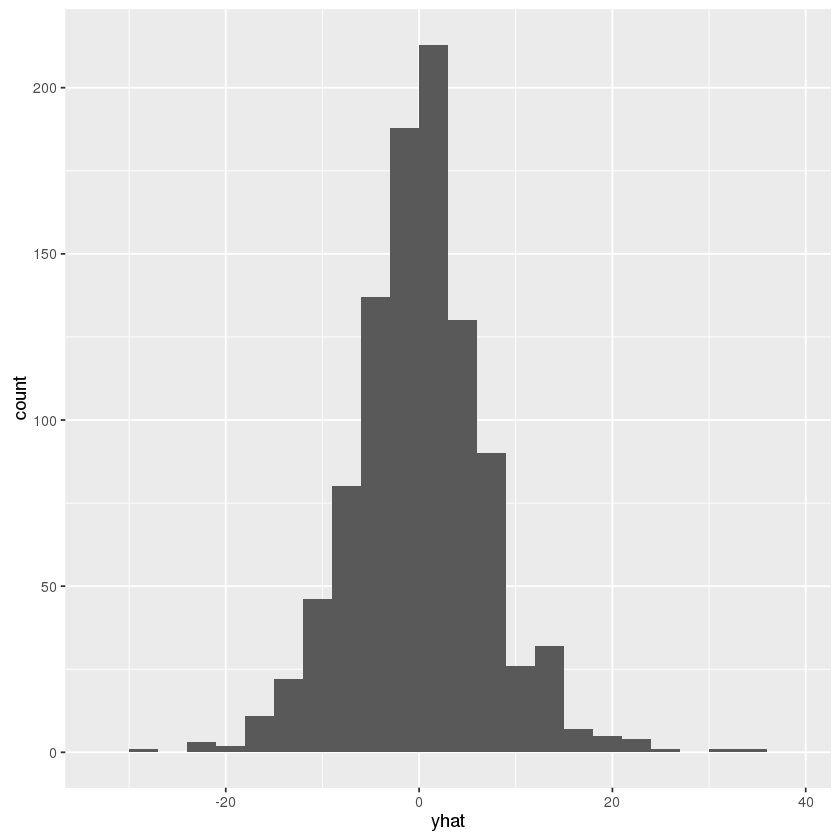

In [7]:
# Draw a vector of random numbers for known Xs and parameters
y_sim <- dgp_rng(N = N, nu = nu, X = X, sigma = sigma, beta = beta)

# Plot the data
data_frame(y_sim = y_sim) %>% # Declare a data frame and pipe it into a ggplot
    ggplot(aes( x = y_sim)) + # Where we state the x-axis aesthetic (our simulated values)
        geom_histogram(binwidth = 3) # And tell ggplot what sort of chart to build

### C) Estimating the model for known parameters

Now we have $y$ and $X$, and we want to estimate $\beta$, $\sigma$ and, depending on the model, $\nu$. We have two candidate probability models that we want to estimate and check which one is a more plausible model of the data. To do this, we need to specify both models in Stan and then estimate them.

Let's jump straight in and define the incorrectly specified model--commented heavily below. It is incorrect as it assumes the draws are coming from a normal distribution. It will also be slightly inefficient as it considers that $\beta_{1}$ could be of any value (even though we might have some reason to believe $\beta_{1}$ is positive). 

In [8]:
# In R, or in your .stan file (contents from within the quotes only)

incorrect_model <- "
data {
  // In this section, we define the data that must be passed to Stan (from whichever environment you are using)

  int N; // number of observations
  int P; // number of covariates
  matrix[N, P] X; //covariate matrix
  vector[N] y; //outcome vector
}
parameters {
  // Define the parameters that we will estimate, as well as any restrictions on the parameter values (standard deviations can't be negative...)

  vector[P] beta; // the regression coefficients
  real<lower = 0> sigma; // the residual standard deviation (note that it's restricted to be non-negative)
}
model {
  // This is where we write out the probability model, in very similar form to how we would using paper and pen

  // Define the priors
  beta ~ normal(0, 5); // same prior for all betas; we could define a different one for each, or use a multivariate prior
  sigma ~ cauchy(0, 2.5);
  
  // The likelihood
  y ~ normal(X*beta, sigma);
}
generated quantities {
  // For model comparison, we'll want to keep the likelihood contribution of each point
  // We will also generate posterior predictive draws (yhat) for each data point. These will be elaborated on below. 
  
  vector[N] log_lik;
  vector[N] yhat;
  for(i in 1:N){
    log_lik[i] <- normal_log(y[i], X[i,]*beta, sigma);
    yhat[i] <- normal_rng(X[i,]*beta, sigma);
  }
}
"

Now we define the correctly specified model. It is the same as above, but with a couple of changes: 

- We define the constrained parameter separately, then join it to the unconstrained parameters
- We define a degrees of freedom parameter `nu`, and give it a prior. 
- The likelihood model assumes the data come from a student t distribution. 

In [9]:
# In R, or in your .stan file (contents from within the quotes only)

correct_model <- "
data {
  int N; // number of observations
  int P; // number of covariates
  matrix[N, P] X; //covariate matrix
  vector[N] y; //outcome vector
}
parameters {
  // We need to define two betas--the first is the restricted value, the next are the others. We'll join these in the next block
  real<lower = 0> beta_1;
  vector[P-1] beta_2; // the regression coefficients
  real<lower = 0> sigma; // the residual scale (note that it's restricted to be non-negative)
  real<lower = 0> nu; 
}
transformed parameters {
  vector[P] beta;
  beta <- append_row(rep_vector(beta_1, 1), beta_2);
}
model {
  // Define the priors
  beta ~ normal(0, 5); // same prior for all betas; we could define a different one for each, or use a multivariate prior. The first beta will have a prior of the N+(0, 5)
  sigma ~ cauchy(0, 2.5);
  nu ~ cauchy(7, 5);

  // The likelihood
  y ~ student_t(nu, X*beta, sigma);
}
generated quantities {
  // For model comparison, we'll want to keep the likelihood contribution of each point
  vector[N] log_lik;
  vector[N] yhat;
  for(i in 1:N){
    log_lik[i] <- student_t_log(y[i], nu, X[i,]*beta, sigma);
    yhat[i] <- student_t_rng(nu, X[i,]*beta, sigma);
  }
}
"

Now that we have specified two models, let's estimate them with the $y$ and $X$ we generated above. 

In [10]:
# In R

# Specify the data list that we will pass to Stan. This gives Stan everything declared in the data{} block. 
data_list_2 <- list(X = X, N = N, y = yhat, P = P)

# Call Stan. You'll need to give it either model_code (like the ones we defined above), a file (.stan file), 
# or a fitted Stan object (fit)
# You should also pass Stan a data list, number of cores to estimate on (jupyter only has access to one), 
# the number of Markov chains to run (4 by default)
# and number of iterations (2000 by default). 
# We use multiple chains to make sure that the posterior distribution that we converge on 
# is stable, and not affected by starting values. 

# The first time you run the models, they will take some time to compile before sampling. 
# On subsequent runs, it will only re-compile if you change the model code. 

incorrect_fit <- stan(model_code = incorrect_model, data = data_list_2, cores = 1, chains = 2, iter = 2000)
correct_fit <- stan(model_code = correct_model, data = data_list_2, cores = 1, chains = 2, iter = 2000)


SAMPLING FOR MODEL '60d1369c4a07abfcaa3bc8354aa44e47' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)# 
#  Elapsed Time: 1.60023 seconds (Warm-up)
#                1.30386 seconds (Sampling)
#                2.90409 seconds (Total)
# 


The following numerical problems occured the indicated number of times after warmup on chain 1
                                                                                count
Exception thrown at line 24: normal_log: Scale parameter is 0, but must be > 0!     2
When a numerical problem occurs, the Metropolis proposal gets rejected.
However, by design Metropolis proposals sometimes get rejected even when there are no numerical problems.
Thus, if the number in the 'count' column is small, do not ask about this message on stan-users.



SAMPLING FOR MODEL '60d1369c4a07abfcaa3bc8354aa44e47' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 2, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 2, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 2, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 2, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 2, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 2, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 2, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 2, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 2, Iteration: 2000 / 2000 [100%]  (Sampling)# 
#  Elapsed Time: 1.63293 seconds (Warm-up)
#                1.47831 seconds (Sampling)
#                3.11124 seconds (Total)
# 

SAMPLING FOR MODEL '30377a89656460e888183e9d669e0e93' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 

The following numerical problems occured the indicated number of times after warmup on chain 1
                                                                                                     count
Exception thrown at line 26: student_t_log: Degrees of freedom parameter is inf, but must be finite!     1
Exception thrown at line 26: student_t_log: Scale parameter is 0, but must be > 0!                       1
When a numerical problem occurs, the Metropolis proposal gets rejected.
However, by design Metropolis proposals sometimes get rejected even when there are no numerical problems.
Thus, if the number in the 'count' column is small, do not ask about this message on stan-users.



SAMPLING FOR MODEL '30377a89656460e888183e9d669e0e93' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 2, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 2, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 2, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 2, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 2, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 2, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 2, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 2, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 2, Iteration: 2000 / 2000 [100%]  (Sampling)# 
#  Elapsed Time: 2.79468 seconds (Warm-up)
#                2.62015 seconds (Sampling)
#                5.41483 seconds (Total)
# 


The following numerical problems occured the indicated number of times after warmup on chain 2
                                                                                                     count
Exception thrown at line 26: student_t_log: Degrees of freedom parameter is inf, but must be finite!     1
When a numerical problem occurs, the Metropolis proposal gets rejected.
However, by design Metropolis proposals sometimes get rejected even when there are no numerical problems.
Thus, if the number in the 'count' column is small, do not ask about this message on stan-users.


We have now fit our two competing models to the data. What has been estimated? 

#### What do these fitted objects contain? 

If you are accustomed to estimating models using OLS, Maximum Likelihood or GMM, then you may expect point estimates for parameters: regression tables contain an estimate of the parameter along with some standard errors. Bayesians tend not to use point estimates, but instead estimate parameter _distributions_. For all but a few models, estimating posterior distributions cannot be done analytically, and so we use the Monte Carlo estimate of the distribution. 

Monte Carlo approximation is quite simple. Let's say a parameter $\theta$ is distributed according to some distribution  $\mbox{SomeDistribution()}$ for which we have no analytical formula, but from which we can generate draws. We want to make inference about this distribution; we want its expected value, median, standard deviation, quantiles, etc. The Monte Carlo method allows us to make these inferences by simply generating many **independent** draws from the distribution and then calculating the statistic of interest from those draws. 

For example, we want to estimate the mean of $\mbox{SomeDistribution()}$. All we need is a large number $N$ of independent draws of $\theta_{k} \sim \mbox{SomeDistribution()}$, then we can estimate $E[\theta] = \frac{1}{N}\sum_{n=1}^{N}\theta_{n}$. The standard error of this estimate decreases at $O(1/\sqrt{\mbox{number of independent draws}})$. 

A fitted Stan object contains these draws, for every parameter. In the `generated quantities{}` block of the two models above, we also created two more variable types. 

- The first, `log_lik`, is the log-likelihood, which we use for model comparison.  We obtain this value for each parameter draw, for each value of $y_{i}$. Thus if you have $N$ observations and `iter` parameter draws, this will contain $N\times$ `iter` log-likelihood values (be warned if estimating models on a many data points). 

- The second, `yhat`, is a _posterior predictive draw_. For each parameter draw, we draw a plausible value of each observation of $y$ from the data model. So rather than each observation having a "predicted value", it now has a predictive distribution that takes into account both the regression residual _and_ uncertainty in the parameter estimates. 


#### Some remaining questions

It is premature to take our fitted models and generate inference or prediction. A few questions remain: 

1. Did our estimates of the posterior distribution converge? 
2. Were there any other problems in the model fitting? 
3. Which model is better?

### D) Checking model fit with `shinystan`

To address questions 1 and 2 above, we need to examine the parameter draws from the model to check for a few common problems: 

- **Lack of mixing**. We have run several Markov chains using different starting values. This is a good way of working out whether we are actually converging on a common posterior distribution. If the chains don't "mix", then it's unlikely we're sampling from a well specified posterior. The most common reason for this error is a poorly specified model. 
- **Stationarity**. Markov chains should be covariance stationary (mean and variance of the chain should not depend on when you draw the observations). This is normally the consequence of a poorly specified model or insufficient number of iterations. 
- **Autocorrelation**. Especially in poorly specified or weakly identified models, a given draw of parameters can be highly dependent on the previous draw of the parameters. This results in Monte Carlo estimates not being reliable. If you have checked the model specification, then _thinning_ (keeping every n-th draw) is one approach to fixing the problem--though not ideal. [Reparameterising the model](http://mc-stan.org/documentation/) is normally the best approach to this problem. (See section 21 of the manual, on Optimizing Stan code). 
- **Divergent transitions**. In models with very curved or irregular posterior densities, we often get "divergent transitions". This means that the model may not have sampled well, and may require a respecification or changes to the sampling routine. The easiest way of addressing this issue is to use `control = list(adapt_delta = 0.99)` or some other number close to 1. This will slow down the model fitting, but can help with divergent transitions. 

To check all of these potential problems, we use a tool in `R` called `shinystan`. You can install it with `install.packages("shinystan", dependencies = T)`, and run it with `shinystan::launch_shinystan(correct_fit)`. It will bring up an interactive session in your web browser within which you can explore the estimated parameters. More information on shinystan is available [here](https://github.com/stan-dev/shinystan/wiki).



### E) Comparing models

Let's start by looking at the model outputs. The draws from each parameter can be neatly summarized with `print`:

In [12]:
# In R:

print(incorrect_fit, pars = c("beta", "sigma"))
# Notice that we specify which parameters we want; else we'd get values for `log_lik` and `yhat` also

# Some things to note: 

# - mean is the mean of the draws for each observation
# - se_mean is the Monte Carlo error (standard error of the Monte Carlo estimate from the true mean)
# - sd is the standard deviation of the parameter's draws
# - the quantiles are self-explanatory
# - n_eff is the effective number of independent draws. If there is serial correlation between sequential draws, 
#   the draws cannot be considered independent. In Stan, high serial correlation is typically a problem in 
#   poorly specified models
# - Rhat: this is the Gelman Rubin convergence diagnostic. Values close to 1 indicate that the multiple chains
#   that you estimated have converged to the same distribution and are "mixing" well. 

Inference for Stan model: 60d1369c4a07abfcaa3bc8354aa44e47.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
beta[1]   1.34       0 0.20  0.95  1.21  1.34  1.47  1.73  2000    1
beta[2]  -0.22       0 0.21 -0.63 -0.35 -0.22 -0.08  0.20  2000    1
beta[3]   0.03       0 0.20 -0.36 -0.10  0.03  0.17  0.41  2000    1
beta[4]  -0.42       0 0.21 -0.84 -0.55 -0.41 -0.28 -0.01  1912    1
beta[5]   0.78       0 0.20  0.39  0.64  0.78  0.91  1.19  2000    1
beta[6]  -1.49       0 0.19 -1.86 -1.62 -1.49 -1.36 -1.13  2000    1
beta[7]   0.75       0 0.21  0.35  0.61  0.75  0.89  1.16  2000    1
beta[8]  -1.36       0 0.20 -1.74 -1.50 -1.36 -1.23 -1.00  2000    1
beta[9]   0.67       0 0.20  0.28  0.53  0.68  0.81  1.06  2000    1
beta[10] -0.20       0 0.20 -0.59 -0.33 -0.20 -0.06  0.19  2000    1
sigma     6.28       0 0.14  6.01  6.18  6.28  6.37  6.56  1996

In [13]:
# In R

print(correct_fit, pars = c("beta", "sigma", "nu"))

Inference for Stan model: 30377a89656460e888183e9d669e0e93.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
beta[1]   1.19    0.00 0.18  0.83  1.06  1.19  1.31  1.55  2000    1
beta[2]  -0.14    0.00 0.19 -0.49 -0.27 -0.15 -0.02  0.26  2000    1
beta[3]  -0.03    0.00 0.17 -0.37 -0.14 -0.04  0.07  0.29  2000    1
beta[4]  -0.37    0.00 0.19 -0.73 -0.49 -0.36 -0.24 -0.01  2000    1
beta[5]   0.88    0.00 0.18  0.53  0.76  0.88  1.00  1.23  2000    1
beta[6]  -1.60    0.00 0.18 -1.95 -1.72 -1.60 -1.48 -1.26  2000    1
beta[7]   0.80    0.00 0.18  0.45  0.68  0.81  0.92  1.15  2000    1
beta[8]  -1.32    0.00 0.19 -1.69 -1.45 -1.32 -1.20 -0.96  2000    1
beta[9]   0.64    0.00 0.18  0.28  0.52  0.64  0.76  0.98  2000    1
beta[10] -0.14    0.00 0.19 -0.51 -0.26 -0.13 -0.01  0.23  2000    1
sigma     4.99    0.00 0.19  4.60  4.86  4.99  5.12  5.37  1580

It's often useful to plot the parameter estimates against the known values. If all is good, your estimated parameter densities should have a reasonable weight on the true value. 

No id variables; using all as measure variables


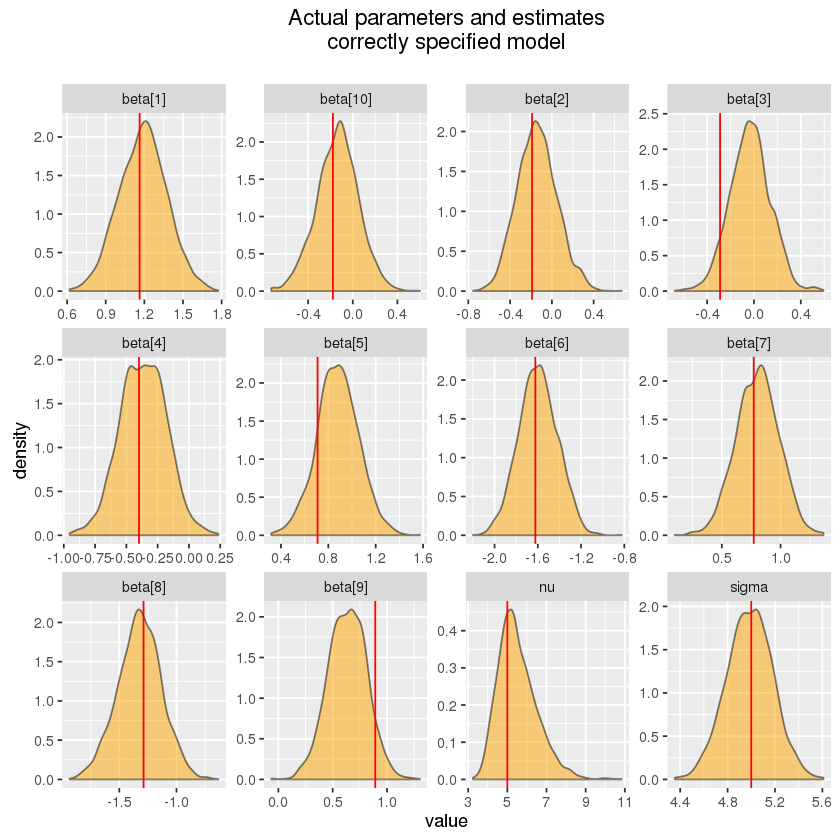

In [14]:
# In R

# Declare a data frame that contains the known parameter names in one column `variable` and their known values
known_parameters <- data_frame(variable = c(paste0("beta[",1:P,"]"),"sigma", "nu"), real_value = c(beta, sigma, nu))


# Extract params as a (draws * number of chains * number of params) array
extract(correct_fit, permuted = F, pars = c("beta", "sigma", "nu")) %>% 
# Stack the chains on top of one another and drop the chains label
    plyr::adply(2) %>% 
    dplyr::select(-chains) %>% 
# Convert from wide form to long form (stack the columns on one another)
    melt() %>% 
# Perform a left join with the known parameters
    left_join(known_parameters, by = "variable") %>%
# Generate the plot
    ggplot(aes(x = value)) + 
    geom_density(fill = "orange", alpha = 0.5) + # Make it pretty
    facet_wrap(~ variable, scales = "free") +
    geom_vline(aes(xintercept = real_value), colour = "red") +
    ggtitle("Actual parameters and estimates\ncorrectly specified model\n")


No id variables; using all as measure variables


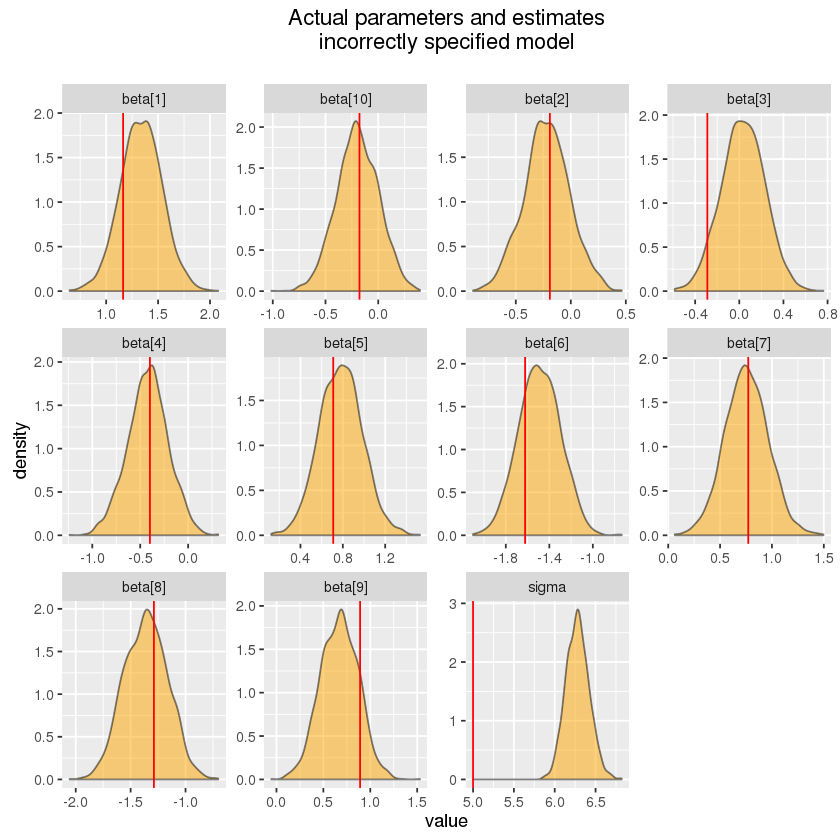

In [15]:

extract(incorrect_fit, permuted = F, pars = c("beta", "sigma")) %>% 
# Extract params as a (draws * number of chains * number of params) array
    plyr::adply(2) %>% 
    dplyr::select(-chains) %>% 
# Stack the chains on top of one another and drop the chains label
    melt() %>% 
    left_join(known_parameters, by = "variable") %>% # Join the known parameter table
# Convert from wide form to long form (stack the columns on one another)
# Write out the plot
    ggplot(aes(x = value)) + 
    geom_density(fill = "orange", alpha = 0.5) + # Make it pretty
    facet_wrap(~ variable, scales = "free") + # small sub-plots of each variable
    geom_vline(aes(xintercept = real_value), colour = "red") + # red vertical lines for the known parameters
    ggtitle("Actual parameters and estimates\nincorrectly specified model\n") # A title

At the moment, it seems as though both our models have done about as good a job at estimating the regression coefficients $\beta$ as one another. But the incorrectly specified model severely overestimates $\sigma$. This makes sense--a Student-t distribution with $\nu=5$ will have fat tails, and so a normal distribution will try to replicate the extreme values by having a large variance. 

How else might we compare the two models? 

One approach is to use the `loo` package. The idea of this package is to approximate each model's leave-one-out (LOO) cross-validation error, allowing model comparison by the "LOO Information Criterion". This package estimates $\sum_{n = 1}^{N}\log p(y_{n} \, | \, y_{1}, ..., y_{n-1}, y_{n+1}, ..., y_{N})$ without re-estimating the model N times. A big upside of this approach is that it enables us to generate probabilistic estimates of the degree to which each model is most likely to produce the best predictions. We use `loo` like so: 

In [17]:
# in R

library(loo) # Load the library

# Extract the log likelihoods of both models. Note that we need to declare log_lik in the generated quantities {} block
llik_incorrect <- extract_log_lik(incorrect_fit, parameter_name = "log_lik")
llik_correct <- extract_log_lik(correct_fit, parameter_name = "log_lik")

# estimate the leave-one-out cross validation error 
loo_incorrect <- loo(llik_incorrect)
loo_correct <- loo(llik_correct)

# Print the LOO statistics
print("Incorrect model")
print(loo_incorrect)
sprintf("\n\nCorrect model")
print(loo_correct)

# Print the comparison between the two models
print(compare(loo_incorrect, loo_correct), digits = 2)

[1] "Incorrect model"
Computed from 2000 by 1000 log-likelihood matrix

         Estimate   SE
elpd_loo  -3262.1 33.3
p_loo        12.2  1.1
looic      6524.1 66.6

All Pareto k estimates OK (k < 0.5)


[1] "\n\nCorrect model"

Computed from 2000 by 1000 log-likelihood matrix

         Estimate   SE
elpd_loo  -3226.8 29.1
p_loo        12.0  0.5
looic      6453.6 58.1

All Pareto k estimates OK (k < 0.5)
elpd_diff        se 
    35.24     12.49 


The statistic `elpd_loo` is the expected log pointwise predictive density. It is a rough analogy to the log likelihood of a model. `p_loo` gives us the effective number of parameters. We can multiply `elpd_loo` by $-2$ to calculate the `looic`, which you can think of like AIC or BIC (on the deviance scale), but coming from our Bayesian framework. For further details on these statistics, please consult [this paper](http://arxiv.org/abs/1507.04544). 

The `elpd_diff` gives us the expected difference in log posterior density between the two (or more) models. A value for `elpd_diff` greater than zero indicates that the second model generates more plausible predictions than the first model--which is precisely what we expect. 

### F) Generating posterior predictions for our model

Now we have settled on a model to use for inference and/or prediction, we can go about producing some predictions. 

As mentioned above, in Bayesian analysis we do not have _predicted values_ but _predictive distributions_. 

Recall our data model: $y_{i} \sim \mbox{Student-t}(\nu, X_{i}\beta, \sigma)$. Under this model, we are assuming fixed values of the parameters. But we have just estimated a model for which we have many plausible values of $\nu$, $\beta$ and $\sigma$. These plausible values come from our _posterior distribution_. This brings us to the  _posterior predictive distribution_. 

Posterior predictions are constructed by: 
1. Drawing a set of parameters $\theta^{\mathrm{draw}}$ from the posterior distribution
2. For each observation $i$, draw a value $y_{i}^{\mathrm{sim}}$ from $p(y\, |\, \theta^{\mathrm{draw}}, X_{i})$
3. Repeat for all parameter draws. 


For each data point, we end up with as many plausible outcomes as we have draws from the posterior. **These draws take into account both the expected variation in the data model and also our posterior uncertainty**. This allows us use the Monte Carlo method to calculate statistics for prediction. 
        
   

No id variables; using all as measure variables


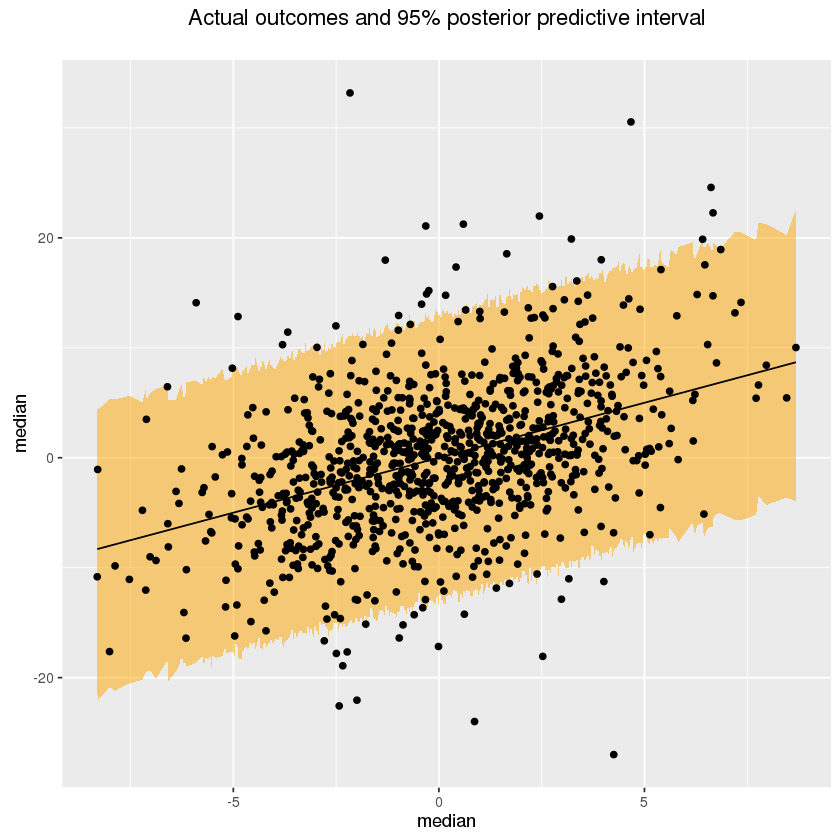

In [21]:
# In R

known_y <- data_frame(variable = paste0("yhat[",1:N,"]"), real_y = yhat)


# Extract params as a (draws * number of chains * number of params) array
plot_data <- extract(correct_fit, permuted = F, pars = c("yhat")) %>%
    plyr::adply(2) %>% 
    dplyr::select(-chains) %>% 
# Stack the chains on top of one another and drop the chains label
    melt() %>% 
    left_join(known_y, by = "variable") %>% # Join the known parameter table
# Convert from wide form to long form (stack the columns on one another)
# Write out the plot
    group_by(variable) %>%
    summarise(median = median(value),
              lower = quantile(value, 0.025),
              upper = quantile(value, 0.975),
              actual = first(real_y)) 

plot_data %>%
    ggplot(aes(x = median)) + 
    geom_ribbon(aes(ymin = lower, ymax = upper), fill = "orange", alpha = 0.5) + 
    geom_line(aes(y = median)) +
    geom_point(aes(y = actual)) +
    ggtitle("Actual outcomes and 95% posterior predictive interval\n") # A title

So what proportion of actual values fell within the 95% posterior predictive interval? 


In [25]:
plot_data %>% summarize(proportion_within_95pc = mean(actual>=lower & actual<=upper))

,proportion_within_95pc
1,0.952


That's not too bad! 

### G) Getting help

Stan has a well-written manual and thriving online community. I would recommend subscribing to the [Stan Users Group](https://groups.google.com/forum/#!forum/stan-users), which has daily email threads on a wide range of modeling problems and coding issues. 

The [Stan modeling language manual and example models](http://mc-stan.org/documentation/) also contains a huge amount of information on the language, as well as a variety of common models that are ready to go. 

If you are estimating generalised linear models and varying-intercept, varying-slope models, you should use [`rstanarm`](http://mc-stan.org/interfaces/rstanarm.html). This package uses Stan in the back-end, but does not require the user to write Stan models. 


### Coming up

This concludes this introductory tutorial to Stan. I'd love your feedback on how to

a) make it easier to follow
b) hear about what sort of tutorials you would like in the future. I am planning to write some on: 

- Basic time-series models
- Instrumental variables
- VAR/SVAR
- GARCH/M-GARCH
- Time-varying parameter models
- Reparameterizing models for high-performance sampling.

If you have any thoughts on which you'd like next, please drop me a line at james@lendable.io


